# Importing Libraries 

In [83]:
# Importing all neccesary libraries
import pandas as pd # Pandas
import numpy as np # Numpy
from scipy import stats # Scipy - for statistics
import matplotlib.pyplot as plt # Matplotlib - for ploting
import seaborn as sns # Seaborn - for ploting
from sklearn import linear_model
from sklearn.linear_model import LinearRegression


# Importing Data

In [84]:
# Importing Data 
all_college_df = pd.read_csv("College.csv")# Importing GDP data for all countries
f100_df = pd.read_csv("FTSE100.csv") # Importing fertility data
monthly_hp_df = pd.read_excel("Monthly.xls") # Importing Isreali unemployment data
israeli_df = pd.read_csv("Israeli_Unemployment_Rate.csv") # Importing Isreali unemployment data 

# Cleaning Data (Relabeling columns, sorting data)
monthly_hp_df['Unnamed: 0'] = pd.to_datetime(monthly_hp_df['Unnamed: 0']) 
house_price_df = monthly_hp_df.rename(columns={'Unnamed: 0' : 'Date'})

f100_df['Date'] = pd.to_datetime(f100_df['Date'])
f100_df = f100_df.sort_values(by = 'Date') # Sorting f100 data by date

# Seleecting data from Jan 1991 to Dec 2016
house_price_df = house_price_df[(house_price_df['Date'] >= '1991-01-01') & (house_price_df['Date'] <= '2016-12-01')]

# Merging both dataframes
merged_df = pd.merge(f100_df, house_price_df, on='Date')
merged_df = merged_df[['Date', 'Adj Close', 'Average House Price']] # Selecting the columns we need

# Viewing the data
#f100_df.head()
#house_price_df.tail()
#merged_df.tail()

# Question 1

Creating a regression model and calculating the correlation coefficient between the FTSE100 and the house price index.

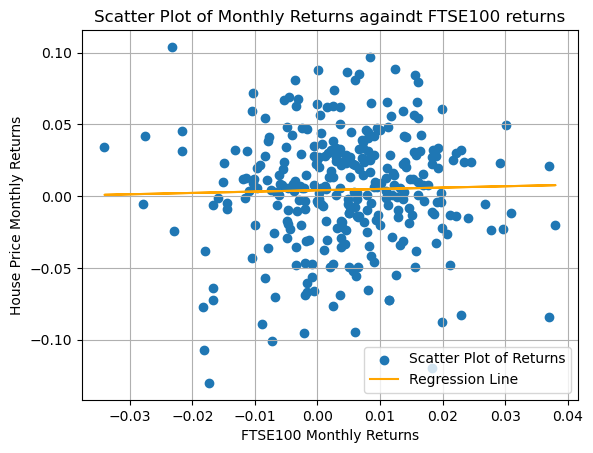

Slope: 0.09324142754349966
Intercept: 0.004047837686662456


In [85]:
# Calculating monthly returns for both data sets
f100_df['FTSE100 Return'] = f100_df['Adj Close'].pct_change()
house_price_df['House Price Return'] = house_price_df['Average House Price'].pct_change()

# Removing NaN values
f100_df = f100_df.dropna(subset=['FTSE100 Return'])
house_price_df = house_price_df.dropna(subset=['House Price Return'])

# Linear regression using stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(house_price_df['House Price Return'], f100_df['FTSE100 Return'])
hp_predict = intercept + slope * house_price_df['House Price Return']

# Plotting data and regression line
plt.scatter(house_price_df['House Price Return'], f100_df['FTSE100 Return'], label='Scatter Plot of Returns')
plt.plot(house_price_df['House Price Return'], hp_predict, color='orange', label='Regression Line')
plt.xlabel('FTSE100 Monthly Returns')
plt.ylabel('House Price Monthly Returns')
plt.title('Scatter Plot of Monthly Returns againdt FTSE100 returns')
plt.legend()
plt.grid(True)
plt.show()

# Pearson Correlation Coefficient Significance Test
corr, p_value = stats.pearsonr(house_price_df['House Price Return'], f100_df['FTSE100 Return'])

print('Slope:', slope)
print('Intercept:', intercept)



Using a hypothesis test to back up conclusion about the existence of a significant relationship between these two variables.

In [86]:
# Pearson Correlation Coefficient Significance Test
corr, p_value = stats.pearsonr(house_price_df['House Price Return'], f100_df['FTSE100 Return'])
#print('---------------------------------')
print('Correlation:', corr)
print('P-Value:', p_value)

Correlation: 0.02655129570190993
P-Value: 0.6409049000031662


# Question 2

Intercept (Constant):  63.50816283700902
Slope (Coefficient):  0.0006513634877409254
R-Squared:  0.021536912489401476
P-Value:  4.018555560836049e-05
Standard Error:  0.00015770775910070958
               Apps    Enroll  Top10perc  Top25perc  Outstate  Grad.Rate
Apps       1.000000  0.846822   0.338834   0.351640  0.050159   0.146755
Enroll     0.846822  1.000000   0.181294   0.226745 -0.155477  -0.022341
Top10perc  0.338834  0.181294   1.000000   0.891995  0.562331   0.494989
Top25perc  0.351640  0.226745   0.891995   1.000000  0.489394   0.477281
Outstate   0.050159 -0.155477   0.562331   0.489394  1.000000   0.571290
Grad.Rate  0.146755 -0.022341   0.494989   0.477281  0.571290   1.000000


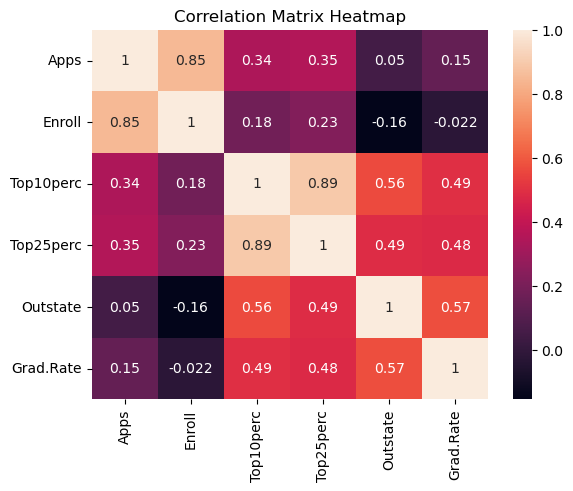

In [87]:
# Selecting necessary columns
college_df = all_college_df[['Apps', 'Enroll', 'Top10perc', 'Top25perc', 'Outstate', 'Grad.Rate']]

# Calculating the correlation between the Apps, Enroll, Top10perc, Top25perc, and Outstate.
correlation = college_df.corr()

# Sterpwise Linear regression using SCIPY
slope, intercept, r_value, p_value, std_err = stats.linregress(college_df['Apps'], college_df['Grad.Rate'])
print('Intercept (Constant): ', intercept)
print('Slope (Coefficient): ', slope) # Coefficient
print('R-Squared: ', r_value**2)
print('P-Value: ', p_value)
print('Standard Error: ', std_err)

slope, intercept, r_value, p_value, std_err = stats.linregress(college_df['Enroll'], college_df['Grad.Rate'])

print(correlation)
sns.heatmap(correlation, annot=True)
plt.title('Correlation Matrix Heatmap')    
plt.show()


In [88]:
# Features 
X = college_df[['Apps', 'Enroll', 'Top10perc', 'Top25perc', 'Outstate']] # Independent variables
y = college_df['Grad.Rate'] # Dependent variable

# Stepwise backward Linear regression model using states model
# Source: https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
def backward_regression(X, y,
                           threshold_out, # P-value threshold for removing variables
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.05}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

print("Selected variables - Stepwise Regression: ",backward_regression(X, y, 0.05,))

# LassoLarsIC selection criteria
reg = linear_model.LassoLarsIC(criterion='bic')
reg.fit(X, y)
#print(reg.coef_)

# Selecting the best BIC variables where the coefficient is less that 0.05
bic_variables = X.columns[np.abs(reg.coef_) < 0.05]
print("BIC selected variables: ", bic_variables)

# Getting the index of Carnegie Mellon University
cmu = all_college_df[all_college_df['Unnamed: 0'] == 'Carnegie Mellon University'].index[0]

# Linear regression model with all variables
model2 = LinearRegression()
model2.fit(X, y)
print("\nAll variables")
print('Intercept:', model2.intercept_)
#print('Coefficients:', model2.coef_)
print('R-Squared:', model2.score(X, y))
y_pred2 = model2.predict(X)
residuals = y - y_pred2
print('CMU rediction using all variables:', y_pred2[cmu])

# Lineregression model with regression variables
y1 = college_df['Grad.Rate']
X1 = college_df[['Apps', 'Enroll', 'Top25perc', 'Outstate']]
model1 = LinearRegression()
model1.fit(X1, y1)
print("\nRegression variables")
print('Intercept:', model1.intercept_)
#print('Coefficients:', model1.coef_)
print('R-Squared:', model1.score(X1, y1))

# Calculatign the accuracy of the model
y_pred1 = model1.predict(X1)
residuals = y1 - y_pred1
print('CMU prediction using backward regression', y_pred1[cmu])

# Linear regression model with BIC selected variables
y2 = college_df['Grad.Rate']
X2 = college_df[['Apps', 'Enroll', 'Top10perc', 'Outstate']]
model3 = LinearRegression()
model3.fit(X2, y2)
print("\nBIC selected variables")
print('Intercept:', model3.intercept_)
#print('Coefficients:', model3.coef_)    
print('R-Squared:', model3.score(X2, y2))
y_pred3 = model3.predict(X2)
residuals = y2 - y_pred3
print('CMU prediction using BIC:', y_pred3[cmu])

#all_college_df.head()



Selected variables - Stepwise Regression:  ['Apps', 'Enroll', 'Top25perc', 'Outstate']
BIC selected variables:  Index(['Apps', 'Enroll', 'Top10perc', 'Outstate'], dtype='object')

All variables
Intercept: 35.896244313183374
R-Squared: 0.3861582005130556
CMU rediction using all variables: 89.20112305346859

Regression variables
Intercept: 34.9300350594477
R-Squared: 0.3856960170430921
CMU prediction using backward regression 89.12510268464595

BIC selected variables
Intercept: 40.79457109110005
R-Squared: 0.3774239848224379
CMU prediction using BIC: 89.08292600009445


# Question 3

Loading Data

In [89]:
# Import data - Mortality caused by road traffic injury (per 100,000 population) from row 5

traffic_death_df = pd.read_csv("death_by_traffic_injury.csv", skiprows=4)
death_aged_20_24 = pd.read_csv("deaths_aged_20_24.csv", skiprows=4) # Number of deaths ages 20-24 years  

# Selecting row where the Country Code = SSA
traffic_death_SSA = traffic_death_df[traffic_death_df['Country Code'] == 'SSA']
death_aged_20_24_SSA = death_aged_20_24[death_aged_20_24['Country Code'] == 'SSA']

# Selecting Country Name, Country Code, and date from 1990 to 2020
traffic_SSA = traffic_death_SSA[['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
death_20_24_SSA = death_aged_20_24_SSA[['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',]]

# Transposing data frame
traffic_SSA = traffic_SSA.T
death_20_24_SSA = death_20_24_SSA.T

# Change column header to 'Motality Rate'
traffic_SSA.columns = ['Deaths by Traffic Injury']
death_20_24_SSA.columns = ['Deaths 20-24']

# Reset index
#traffic_SSA.reset_index(inplace=True)

#traffic_SSA.tail()
#traffic_death_long.tail()

Data Manipulation

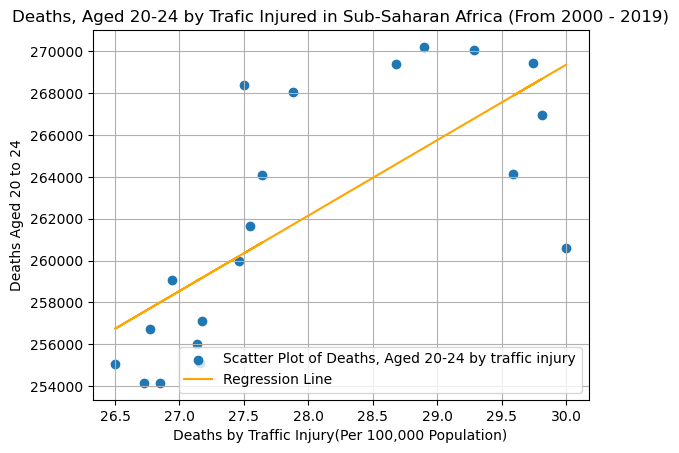

Slope: 3606.2731281060965
Intercept: 161170.99813236602
Correlation: 0.7162475356546606
P-Value: 0.0003820495473939112
Predicted Deaths Aged 20-24 by Traffic Injury in 2021: [260198.89760285]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [90]:
# Linear Regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(traffic_SSA['Deaths by Traffic Injury'], death_20_24_SSA['Deaths 20-24'])
death20_24_predict = intercept + slope * traffic_SSA['Deaths by Traffic Injury']

# Plotting the data and regression line
plt.scatter(traffic_SSA['Deaths by Traffic Injury'], death_20_24_SSA['Deaths 20-24'], label='Scatter Plot of Deaths, Aged 20-24 by traffic injury')
plt.plot(traffic_SSA['Deaths by Traffic Injury'], death20_24_predict, color='orange', label='Regression Line')
plt.xlabel('Deaths by Traffic Injury(Per 100,000 Population)')
plt.ylabel('Deaths Aged 20 to 24')
plt.title('Deaths, Aged 20-24 by Trafic Injured in Sub-Saharan Africa (From 2000 - 2019)')
plt.legend()
plt.grid(True)
plt.show()

# Pearson Correlation Coefficient Significance Test
#corr, p_value = stats.pearsonr(death_20_24_SSA['Deaths 20-24'], traffic_SSA['Deaths by Traffic Injury'])
corr, p_value = stats.pearsonr(traffic_SSA['Deaths by Traffic Injury'], death_20_24_SSA['Deaths 20-24'])

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation:', corr)
print('P-Value:', p_value)  

# Predicting the number of deaths aged 20-24 by traffic injury in 2021
Xi = traffic_SSA[['Deaths by Traffic Injury']]
yi = death_20_24_SSA['Deaths 20-24']

# Model
model = LinearRegression()
model.fit(Xi, yi)

# Predicting the unemployment rate for 2021
year_2021 = np.array([[27.4599]])  # Reshape to 2D array
predicted_rate = model.predict(year_2021)
print('Predicted Deaths Aged 20-24 by Traffic Injury in 2021:', predicted_rate)


# Question 4

Predicted Unemployment Rate for 2020: 11.36%
MAPE: 23.71%
APE for the year 2020: 5.33%


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_22556\1985263333.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  israeli_train_df['Date'] = israeli_train_df['Date'].apply(lambda x: x.toordinal())
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


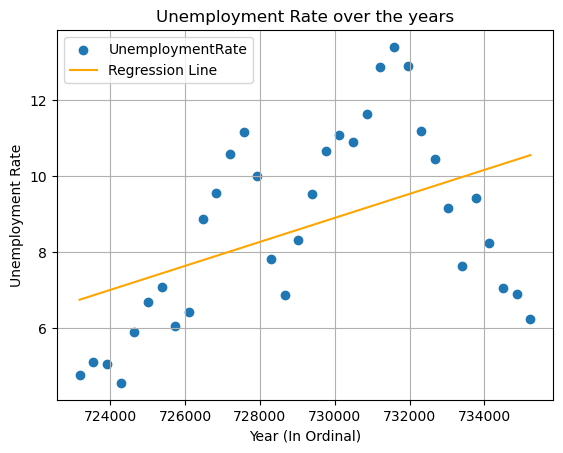

In [91]:
# Formatting the data
israeli_df['Date'] = pd.to_datetime(israeli_df['Date'])

# Selecting values from 1980 to 2013
israeli_train_df = israeli_df[(israeli_df['Date'] >= '1980-01-01') & (israeli_df['Date'] <= '2014-12-01')]
# israeli_train_df date to ordinal
israeli_train_df['Date'] = israeli_train_df['Date'].apply(lambda x: x.toordinal())

X = israeli_train_df[['Date']]
y = israeli_train_df['Value']

# Model
model = LinearRegression()
model.fit(X, y)

# Predicting the unemployment rate for 2020
ord_2020 = pd.to_datetime('2020-12-30').toordinal()
year_2020 = np.array([[ord_2020]])
predicted_rate = model.predict(year_2020)

print(f'Predicted Unemployment Rate for 2020: {predicted_rate[0]:.2f}%')

# Actual value 2020
actual_val_2020 = 12  # Replace with the actual value

# Predicted value
predicted_rate_value = predicted_rate[0]

# Get list of all dates in israeli_train_df converted to ordinal
date_ord_list = israeli_train_df['Date'].tolist()
date_ord_array = np.array(date_ord_list).reshape(-1, 1)

# Calculate MAPE
mape = abs((actual_val_2020 - predicted_rate_value) / actual_val_2020) * 100
ape1 = abs((y - model.predict(date_ord_array)) / y) * 100

mape1 = np.mean(ape1)

# Print the MAPE
print(f'MAPE: {mape1:.2f}%')
print(f'APE for the year 2020: {mape:.2f}%')

# Plotting the data
plt.scatter(israeli_train_df['Date'], israeli_train_df['Value'], label='UnemploymentRate')
plt.plot(israeli_train_df['Date'], model.predict(X), color='orange', label='Regression Line')
plt.xlabel('Year (In Ordinal)')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate over the years')
plt.legend()
plt.grid(True)
plt.show()



#israeli_train_df.head()